## 1. 데이터 이해 및 탐색

[상황]
- 예측할 값(y): SalePrice
- 평가 지표: RMSE

[데이터 설명]

| 변수명          | 설명 |
|----------------|------|
| `SalePrice`    | 주택 판매 가격 (**목표 변수**) |
| `OverallQual`  | 자재 및 마감 품질의 전반적 수준 |
| `GrLivArea`    | 지상 거주 면적 (평방피트) |
| `TotalBsmtSF`  | 지하실 전체 면적 |
| `GarageCars`   | 차고 수용 차량 수 |
| `GarageArea`   | 차고 면적 (평방피트) |
| `YearBuilt`    | 최초 건축 연도 |
| `YearRemodAdd` | 리모델링 연도 |
| `FullBath`     | 지상층의 전체 욕실 수 |
| `TotRmsAbvGrd` | 욕실 제외한 지상 총 방 수 |
| `KitchenQual`  | 주방 품질 |
| `Fireplaces`   | 벽난로 수 |
| `BsmtQual`     | 지하실 높이 |
| `ExterQual`    | 외장재 품질 |
| `Neighborhood` | 주택 위치 (동네/지역) |
| `GarageYrBlt`  | 차고 건축 연도 |
| `MasVnrArea`   | 석재 외장 면적 |
| `LotArea`      | 대지 면적 |
| `LotFrontage`  | 도로에 접한 길이 |

### 1-1. 데이터 살펴보기

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

house_df_org = pd.read_csv('train.csv')
house_df = house_df_org.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,968,20,RL,NaN,7390,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2008,WD,Normal,135000
1,739,90,RL,60.0,10800,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,3,2009,WD,Alloca,179000
2,696,20,RL,54.0,13811,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,7,2006,WD,Normal,176000


In [ ]:
print('데이터 세트의 Shape:', house_df.shape)
print('\n전체 feature 들의 type \n',house_df.dtypes.value_counts())
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))

데이터 세트의 Shape: (1168, 81)

전체 feature 들의 type 
 object     43
int64      35
float64     3
Name: count, dtype: int64

Null 컬럼과 그 건수:
  PoolQC          1162
MiscFeature     1120
Alley           1098
Fence            941
MasVnrType       694
FireplaceQu      545
LotFrontage      218
GarageType        69
GarageYrBlt       69
GarageFinish      69
GarageQual        69
GarageCond        69
BsmtExposure      24
BsmtFinType2      24
BsmtQual          23
BsmtCond          23
BsmtFinType1      23
MasVnrArea         8
Electrical         1
dtype: int64


회귀 모델을 적용하기 전에 타깃 값의 분포도가 정규 분포인지 확인해보자.

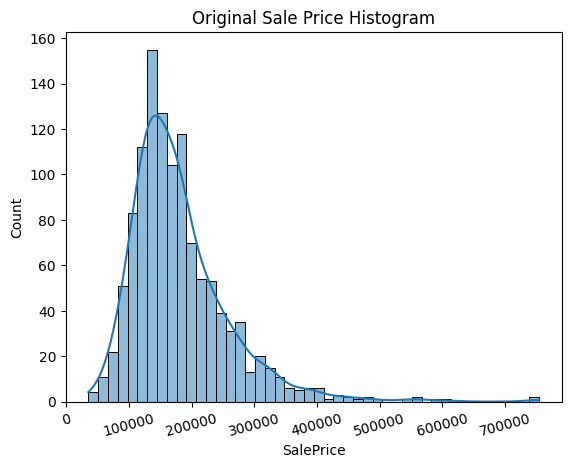

In [ ]:
plt.title('Original Sale Price Histogram')
plt.xticks(rotation=15)
sns.histplot(house_df['SalePrice'], kde=True)
plt.show()

- 데이터 값의 분포가 중심에서 왼쪽으로 치우친 형태로, 정규분포에서 벗어나있다.
---

정규분포가 아닌 결괏값을 정규 분포 형태로 변환하기 위해 로그 변환(Log Transformation)을 적용시키자.
- log1p()를 이용해 로그 변환한 결괏값을 기반으로 학습한 뒤, 예측 시에는 다시 결괏값을 expm1()으로 추후에 환원하면 된다.
- 결괏값을 로그 변환하고 다시 분포도를 살펴보자.

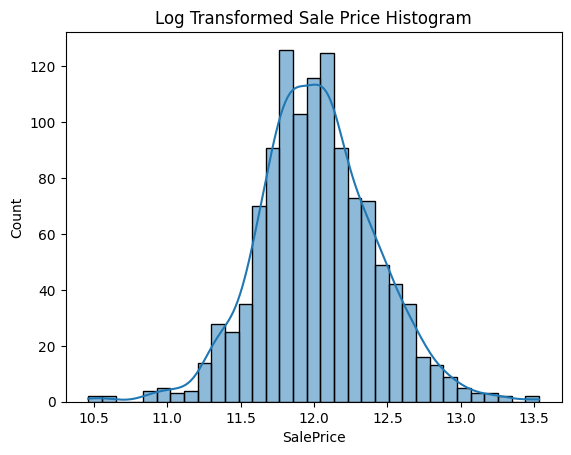

In [ ]:
plt.title('Log Transformed Sale Price Histogram')
log_SalePrice = np.log1p(house_df['SalePrice'])
sns.histplot(log_SalePrice, kde=True)
plt.show()

### 1-2. 상관관계 히트맵

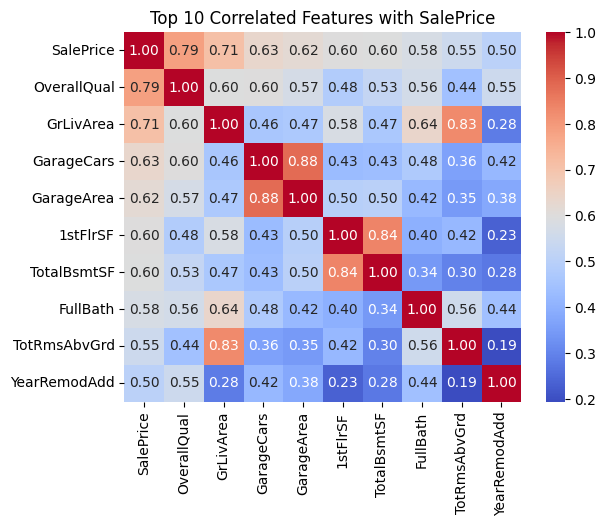

In [ ]:
# 상관관계 히트맵 (수치형 상위 변수들만)
corr = house_df.corr(numeric_only=True)
top_corr_features = corr['SalePrice'].abs().sort_values(ascending=False).head(10).index

sns.heatmap(house_df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Top 10 Correlated Features with SalePrice")
plt.show()

| 변수명            | 상관계수     | 해석                      |
| -------------- | -------- | ----------------------- |
| `OverallQual`  | **0.79** | 전반적인 자재 품질이 높을수록 집값도 상승 |
| `GrLivArea`    | **0.71** | 지상 거주 공간이 클수록 집값 상승     |
| `GarageCars`   | 0.63     | 주차 가능한 차량 수가 많을수록 집값 상승 |
| `GarageArea`   | 0.62     | 차고 면적도 유사하게 영향          |
| `1stFlrSF`     | 0.60     | 1층 면적이 클수록 집값 상승        |
| `TotalBsmtSF`  | 0.60     | 지하 면적도 중요하게 작용          |
| `FullBath`     | 0.58     | 욕실 수가 많을수록 집값 상승        |
| `TotRmsAbvGrd` | 0.55     | 전체 방 개수도 유의미            |
| `YearRemodAdd` | 0.50     | 리모델링이 최근일수록 가치 상승       |

[결과 해석]
1. 품질 > 면적
  - `OverallQuall`은 다른 모든 면적 기반 변수보다 높은 상관계수를 가짐.
    - 단순히 크기보다 품질이 더 중요

2. 면적 관련 변수는 서로 상관관계가 높음
  - 예: 1stFlrSF 와 TotalBsmtSF 간 상관계수 0.84
    - 다중공선성(Multicollinearity)을 유의하자.

3. 차고 정보 (GarageCars, GarageArea)는 각각 의미 있지만 매우 유사한 정보를 포함
  - 둘 중 하나만 사용할 수도 있음.

---

## 2. 데이터 전처리

In [7]:
# SalePrice 로그 변환
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
house_df.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)
# Drop 하지 않는 숫자형 Null컬럼들은 평균값으로 대체
# house_df.fillna(house_df.mean(),inplace=True)
num_cols = house_df.select_dtypes(include=['number']).columns
house_df[num_cols] = house_df[num_cols].fillna(house_df[num_cols].mean())


# Null 값이 있는 피처명과 타입을 추출
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df.dtypes[null_column_count.index])

## Null 피처의 Type :
 MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object


In [8]:
house_df.shape

(1168, 75)

In [9]:
isnull_series = house_df.isnull().sum()
print('\nNull 컬럼과 그 건수:\n ', isnull_series[isnull_series > 0].sort_values(ascending=False))


Null 컬럼과 그 건수:
  MasVnrType      694
GarageQual       69
GarageCond       69
GarageFinish     69
GarageType       69
BsmtFinType2     24
BsmtExposure     24
BsmtCond         23
BsmtQual         23
BsmtFinType1     23
Electrical        1
dtype: int64


이제 문자형 피처를 제외하고는 Null 값이 없음.
- 문자형 피처는 모두 원-핫 인코딩으로 변환하자
  - get_dummies() 이용

In [10]:
print('get_dummies() 수행 전 데이터 Shape:', house_df.shape)
house_df_ohe = pd.get_dummies(house_df)
print('get_dummies() 수행 후 데이터 Shape:', house_df_ohe.shape)

null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
print('## Null 피처의 Type :\n', house_df_ohe.dtypes[null_column_count.index])

get_dummies() 수행 전 데이터 Shape: (1168, 75)
get_dummies() 수행 후 데이터 Shape: (1168, 267)
## Null 피처의 Type :
 Series([], dtype: object)


---

## 3. 모델 선택 & 비교 & 평가

In [11]:
def get_rmse(model):
    pred = model.predict(X_test)
    pred_exp = np.expm1(pred)
    mse = mean_squared_error(np.expm1(y_test) , pred_exp)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    print('{0} 로그 변환된 MSE: {1}'.format(model.__class__.__name__,np.round(mse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [12]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# LinearRegression, Ridge, Lasso 학습, 예측, 평가
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression 로그 변환된 RMSE: 21295.906
LinearRegression 로그 변환된 MSE: 453515626.704
Ridge 로그 변환된 RMSE: 22584.92
Ridge 로그 변환된 MSE: 510078620.219
Lasso 로그 변환된 RMSE: 33922.99
Lasso 로그 변환된 MSE: 1150769232.347


[np.float64(21295.906336752076),
 np.float64(22584.920195102928),
 np.float64(33922.98973184962)]

In [13]:
def get_top_bottom_coef(model):
    # coef_ 속성을 기반으로 Series 객체를 생성. index는 컬럼명.
    coef = pd.Series(model.coef_, index=X_features.columns)

    # + 상위 10개 , - 하위 10개 coefficient 추출하여 반환.
    coef_high = coef.sort_values(ascending=False).head(10)
    coef_low = coef.sort_values(ascending=False).tail(10)
    return coef_high, coef_low

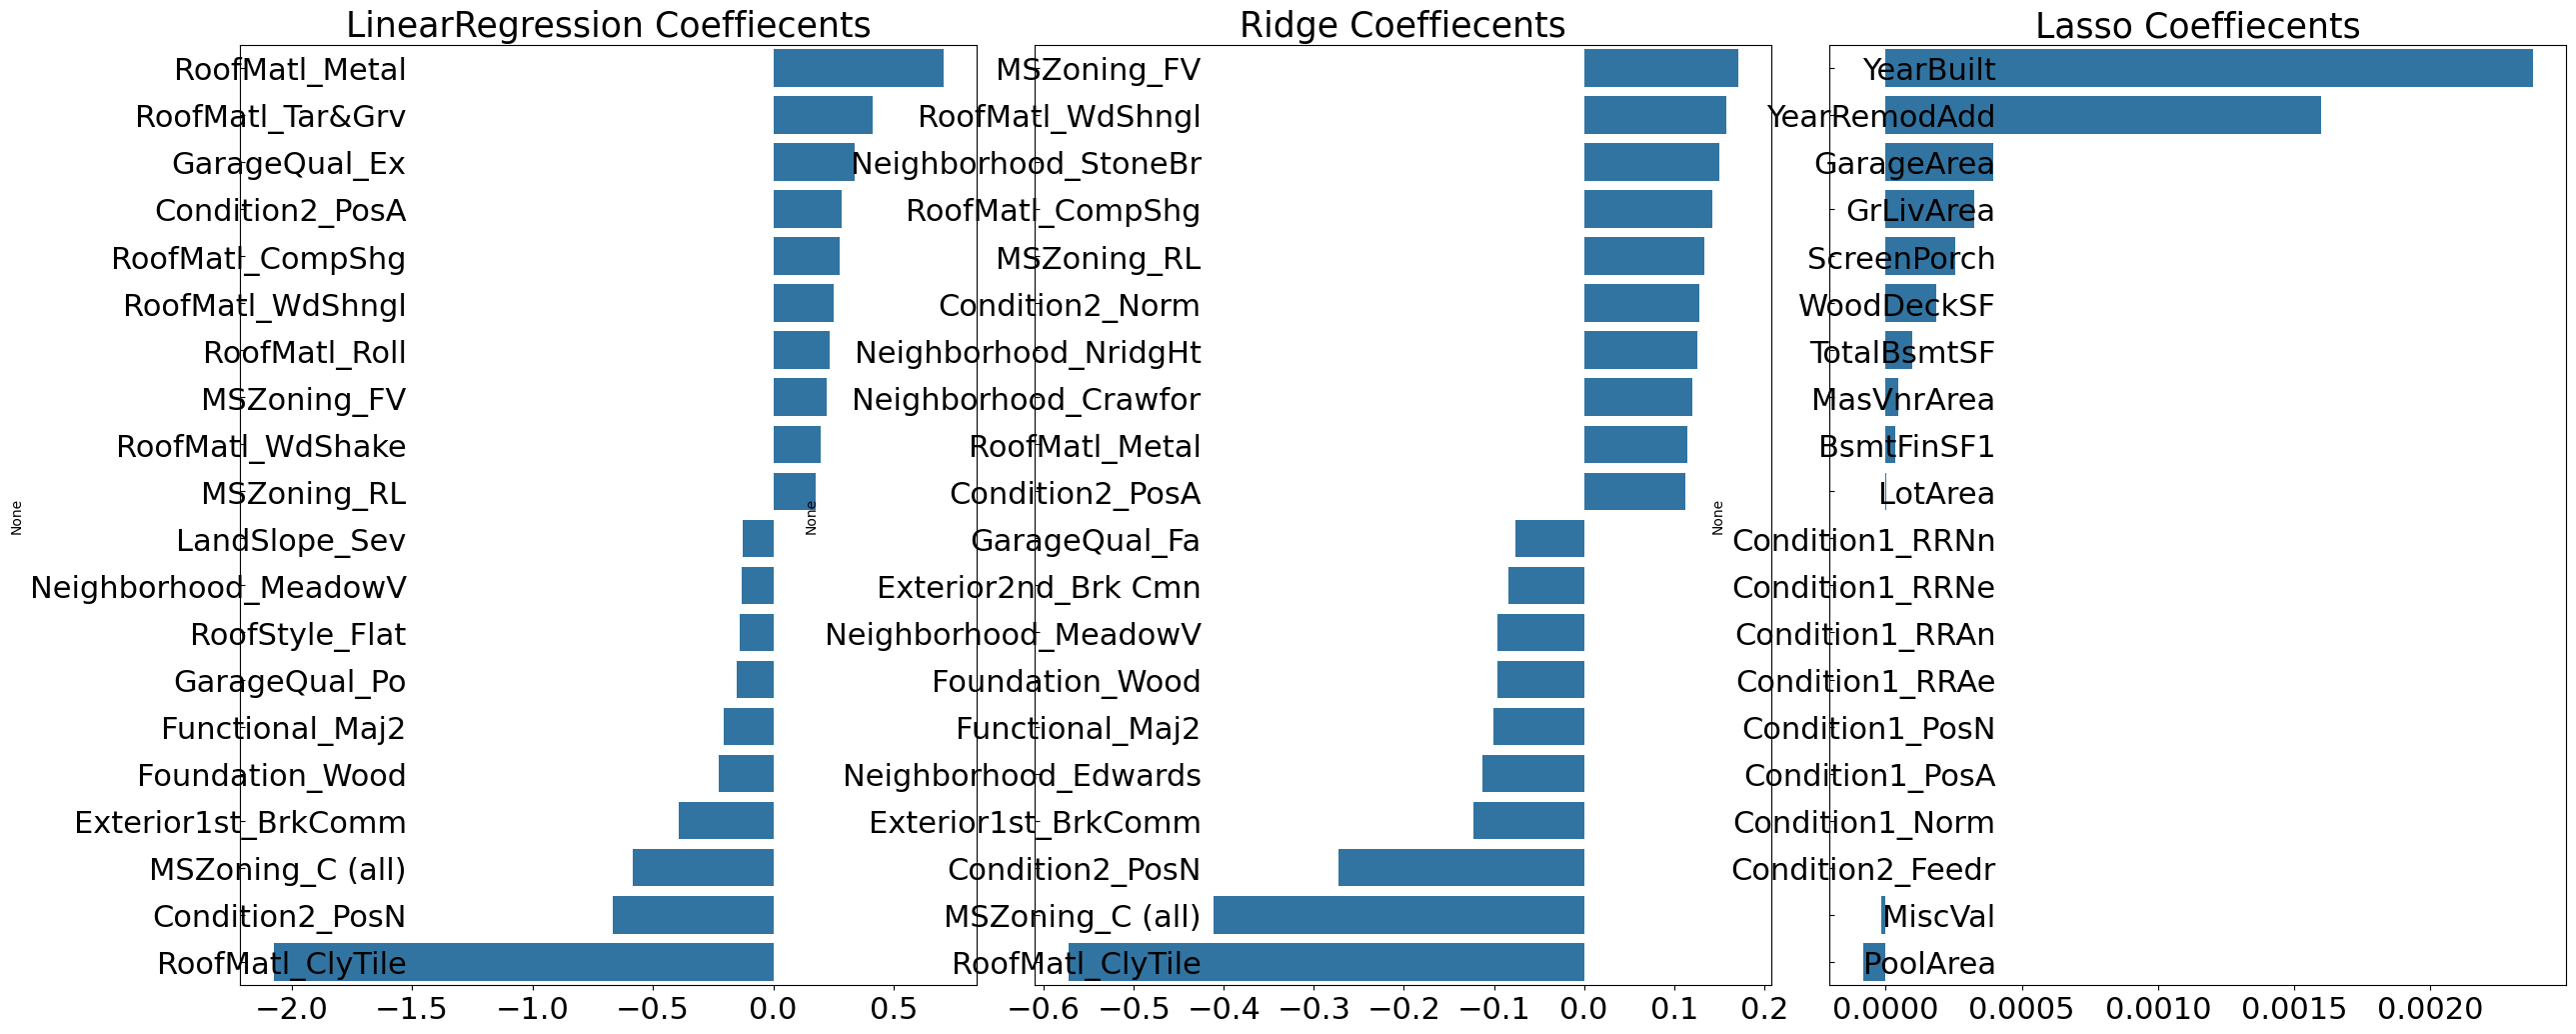

In [14]:
def visualize_coefficient(models):
    # 3개 회귀 모델의 시각화를 위해 3개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 회귀 계수 시각화.
    for i_num, model in enumerate(models):
        # 상위 10개, 하위 10개 회귀 계수를 구하고, 이를 판다스 concat으로 결합.
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat( [coef_high , coef_low] )
        # 순차적으로 ax subplot에 barchar로 표현. 한 화면에 표현하기 위해 tick label 위치와 font 크기 조정.
        axs[i_num].set_title(model.__class__.__name__+' Coeffiecents', size=25)
        axs[i_num].tick_params(axis="y",direction="in", pad=-120)
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=coef_concat.values, y=coef_concat.index , ax=axs[i_num])

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 회귀 계수 시각화.
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- OLS 기반의 LinearRegression과 RIdge의 경우는 회귀계수가 유사한 형태로 분포돼있음.

- 하지만 Lasso는 전체적으로 회귀 계수 값이 매우 작고, 그중에 YearBuilt가 가장 크고 다른 피처의 회귀 계수는 너무 작다.
  - 학습 데이터의 데이터 분할의 문제가 있어서 그런가?
    - train_test_split() 대신 cross_val_score()을 이용해보자.

In [15]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        # 분할하지 않고 전체 데이터로 cross_val_score( ) 수행. 모델별 CV RMSE값과 평균 RMSE 출력
        rmse_list = np.sqrt(-cross_val_score(model, X_features, y_target,
                                             scoring="neg_mean_squared_error", cv = 5))
        rmse_avg = np.mean(rmse_list)
        print('\n{0} CV RMSE 값 리스트: {1}'.format( model.__class__.__name__, np.round(rmse_list, 3)))
        print('{0} CV 평균 RMSE 값: {1}'.format( model.__class__.__name__, np.round(rmse_avg, 3)))

# 앞 예제에서 학습한 lr_reg, ridge_reg, lasso_reg 모델의 CV RMSE값 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)


LinearRegression CV RMSE 값 리스트: [0.247 0.196 0.11  0.129 0.116]
LinearRegression CV 평균 RMSE 값: 0.16

Ridge CV RMSE 값 리스트: [0.213 0.172 0.12  0.131 0.119]
Ridge CV 평균 RMSE 값: 0.151

Lasso CV RMSE 값 리스트: [0.287 0.212 0.173 0.185 0.17 ]
Lasso CV 평균 RMSE 값: 0.205


- 5개의 폴드 세트로 학습한 후 평가해도 여전히 라쏘의 경우 릿지 모델보다 성능이 떨어진다.

### 3-1. 하이퍼 파라미터 작업

`print_best_params(model, params)`는 모델과 하이퍼 파라미터 딕셔너리 객체를 받아 최적화 작업의 결과를 표시하는 함수
- 이 함수를 이용해 릿지 모델과 라쏘 모델의 최적화 alpha 값을 추출해보자.

In [16]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, params):
    grid_model = GridSearchCV(model, param_grid=params,
                              scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X_features, y_target)
    rmse = np.sqrt(-1* grid_model.best_score_)
    print('{0} 5 CV 시 최적 평균 RMSE 값: {1}, 최적 alpha:{2}'.format(model.__class__.__name__,
                                        np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_rige = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1509, 최적 alpha:{'alpha': 12}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.152, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 21295.906
LinearRegression 로그 변환된 MSE: 453515626.704
Ridge 로그 변환된 RMSE: 23159.75
Ridge 로그 변환된 MSE: 536374019.369
Lasso 로그 변환된 RMSE: 23121.426
Lasso 로그 변환된 MSE: 534600337.674


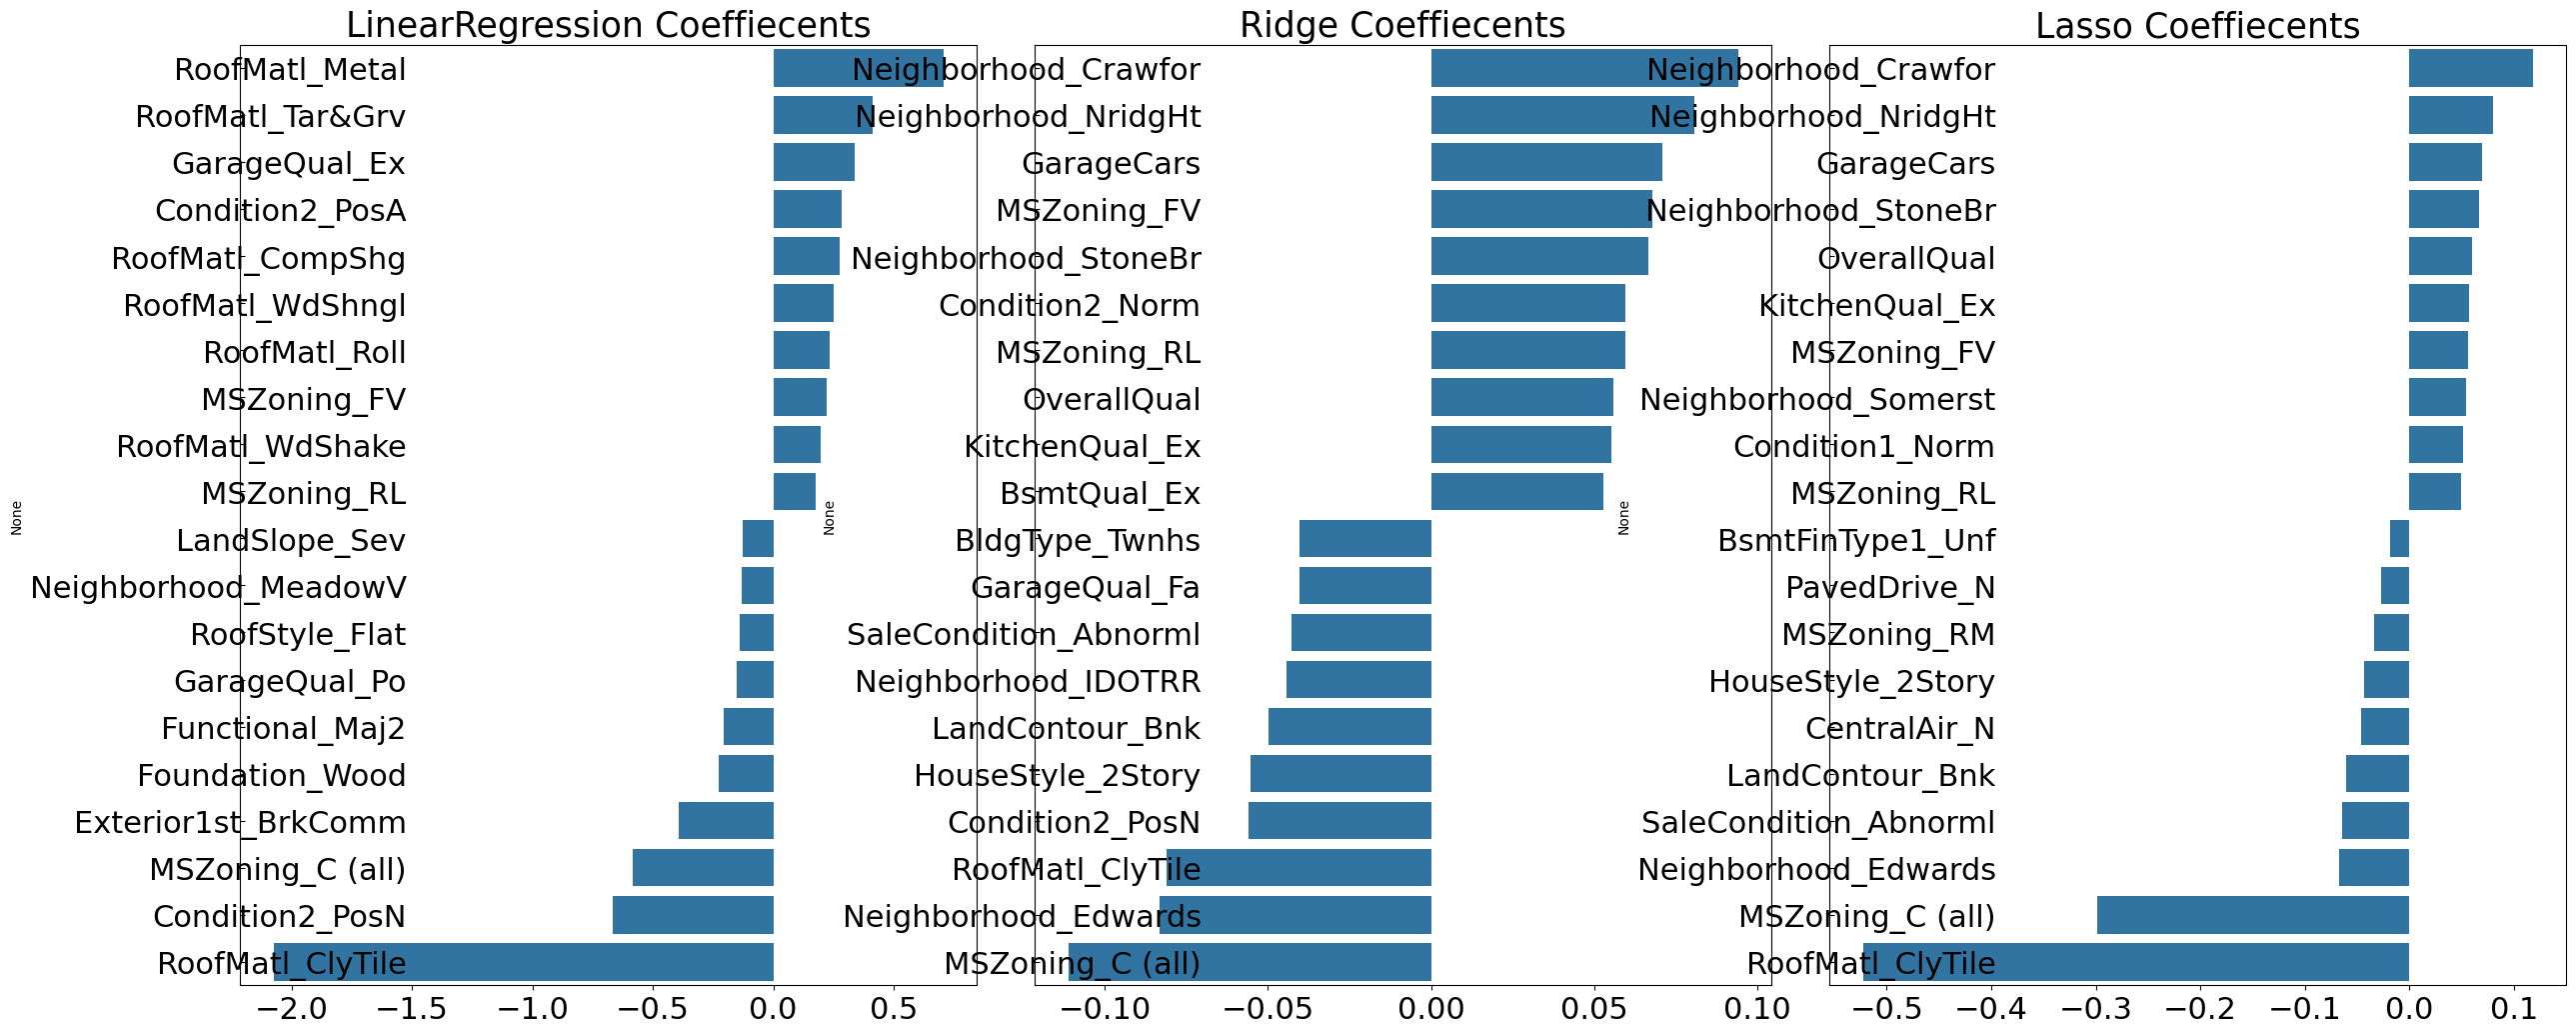

In [17]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- alpha 값 최적화 후 테스트 데이터 세트의 예측 성능이 더 좋아졌다.

  - 데이터를 추가적으로 가공해서 모델 튜닝을 더 진행해보자.

### 3-2. 데이터 전처리 (추가)

In [18]:
from scipy.stats import skew

# object가 아닌 숫자형 피처의 칼럼 index 객체 추출.
features_index = house_df.dtypes[house_df.dtypes != 'object'].index
# house_df에 칼럼 index를 [ ]로 입력하면 해당하는 칼럼 데이터 세트 반환. apply lambda로 skew( ) 호출
skew_features = house_df[features_index].apply(lambda x : skew(x))
# skew(왜곡) 정도가 1 이상인 칼럼만 추출.
skew_features_top = skew_features[skew_features > 1]
print(skew_features_top.sort_values(ascending=False))

MiscVal          22.099034
PoolArea         14.377604
LotArea          11.097791
3SsnPorch        11.040646
LowQualFinSF      9.608861
BsmtFinSF2        4.507199
KitchenAbvGr      4.488325
BsmtHalfBath      4.133732
ScreenPorch       3.976766
EnclosedPorch     3.093917
LotFrontage       2.760540
OpenPorchSF       2.454159
MasVnrArea        2.418589
BsmtFinSF1        1.881057
TotalBsmtSF       1.864686
WoodDeckSF        1.546567
1stFlrSF          1.488257
GrLivArea         1.474257
MSSubClass        1.391605
dtype: float64


추출된 왜곡 정도가 높은 피처를 로그 변환해보자.

In [19]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [20]:
# Skew가 높은 피처들을 로그 변환 했으므로 다시 원-핫 인코딩 적용 및 피처/타겟 데이터 셋 생성,
house_df_ohe = pd.get_dummies(house_df)
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

# 피처들을 로그 변환 후 다시 최적 하이퍼 파라미터와 RMSE 출력
ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1332, 최적 alpha:{'alpha': 8}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1296, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 20177.977
LinearRegression 로그 변환된 MSE: 407150764.073
Ridge 로그 변환된 RMSE: 21542.856
Ridge 로그 변환된 MSE: 464094629.536
Lasso 로그 변환된 RMSE: 22157.381
Lasso 로그 변환된 MSE: 490949533.396


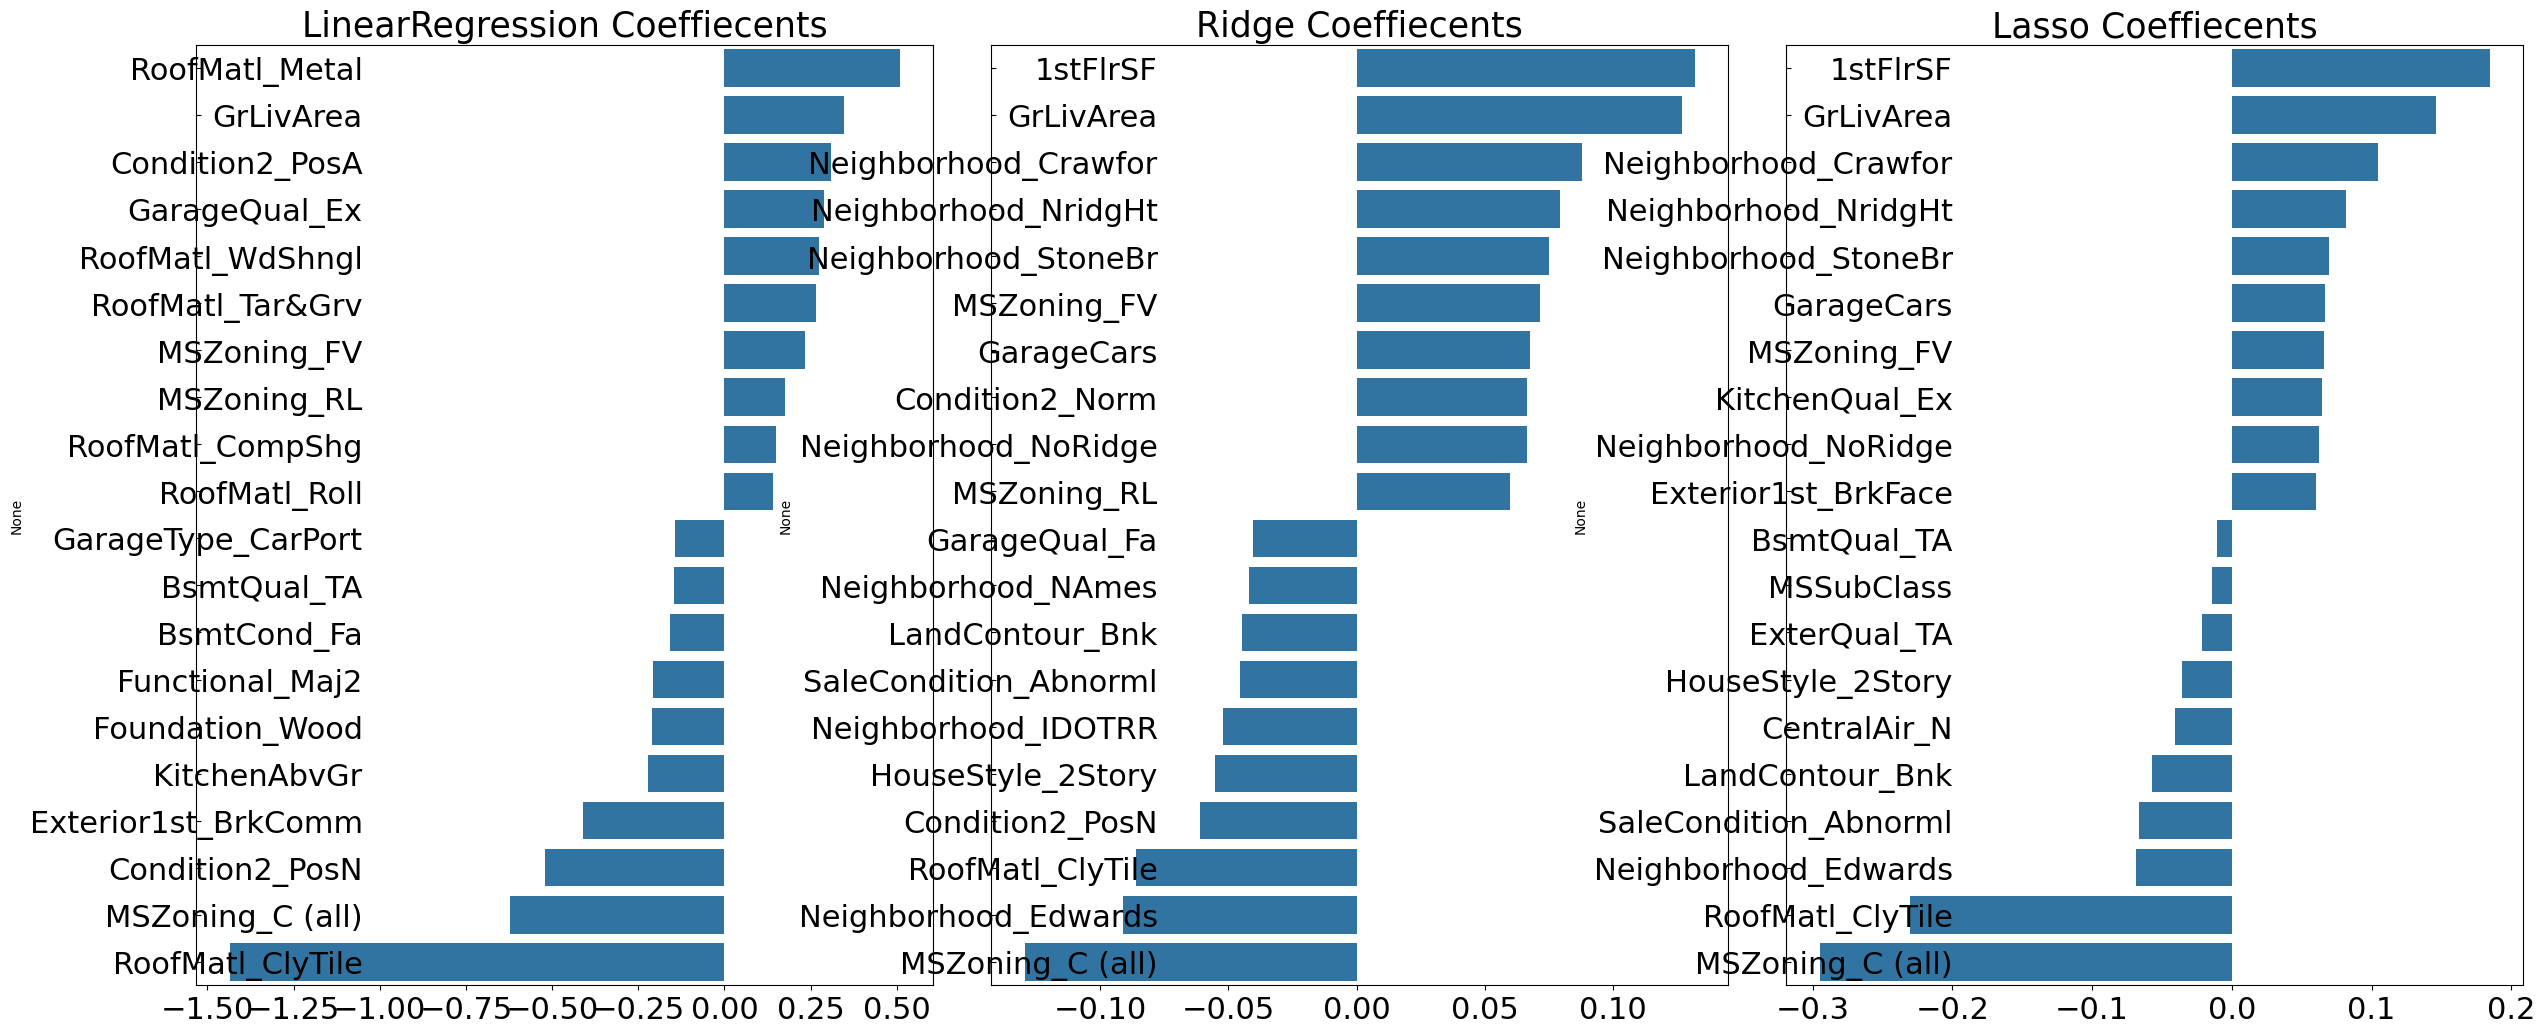

In [21]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

- 세 모델 모두 `GrLivArea`, 즉 주거 공간 크기가 회귀 계수가 가장 높은 피처가 됐다.

  - 주거 공간의 크기가 주택 가격에 미치는 영향이 당연히 제일 높을 것이라는 상식선에서의 결과가 이제야 도출됐다.

- 이상치도 제거해보자.

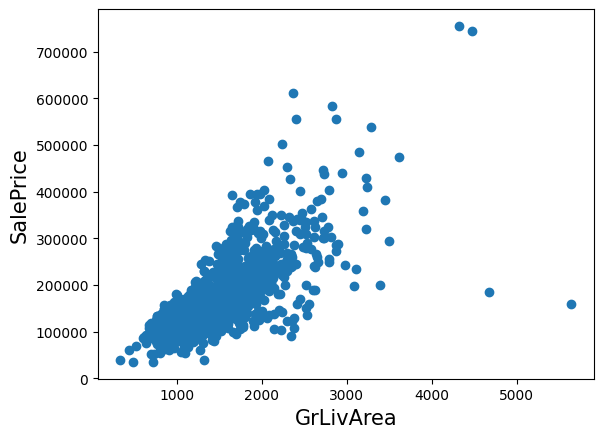

In [22]:
plt.scatter(x = house_df_org['GrLivArea'], y = house_df_org['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

- `GrLivArea`가 4000평방피트 이상임에도 가격이 500,000 달러 이하인 데이터는 모두 이상치로 간주하고 삭제하자.

- 데이터 변환이 모두 완료된 `house_df_ohe`에서 대상 데이터를 필터링하자. `GrLivArea`와 `SalePrice` 모두 로그 변환됐으므로 이를 반영한 조건을 생성한 뒤, 불린 인덱싱으로 대상을 찾자.

In [23]:
# GrLivArea와 SalePrice 모두 로그 변환되었으므로 이를 반영한 조건 생성.
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1 & cond2].index

print('아웃라이어 레코드 index :', outlier_index.values)
print('아웃라이어 삭제 전 house_df_ohe shape:', house_df_ohe.shape)
# DataFrame의 index를 이용하여 아웃라이어 레코드 삭제.
house_df_ohe.drop(outlier_index , axis=0, inplace=True)
print('아웃라이어 삭제 후 house_df_ohe shape:', house_df_ohe.shape)

아웃라이어 레코드 index : [ 64 373]
아웃라이어 삭제 전 house_df_ohe shape: (1168, 267)
아웃라이어 삭제 후 house_df_ohe shape: (1166, 267)


In [24]:
y_target = house_df_ohe['SalePrice']
X_features = house_df_ohe.drop('SalePrice',axis=1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X_features, y_target, test_size=0.2, random_state=156)

ridge_params = { 'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20] }
lasso_params = { 'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1,5, 10] }
best_ridge = print_best_params(ridge_reg, ridge_params)
best_lasso = print_best_params(lasso_reg, lasso_params)

Ridge 5 CV 시 최적 평균 RMSE 값: 0.1149, 최적 alpha:{'alpha': 5}
Lasso 5 CV 시 최적 평균 RMSE 값: 0.1132, 최적 alpha:{'alpha': 0.001}


LinearRegression 로그 변환된 RMSE: 21295.11
LinearRegression 로그 변환된 MSE: 453481721.207
Ridge 로그 변환된 RMSE: 21189.92
Ridge 로그 변환된 MSE: 449012696.14
Lasso 로그 변환된 RMSE: 20410.53
Lasso 로그 변환된 MSE: 416589738.56


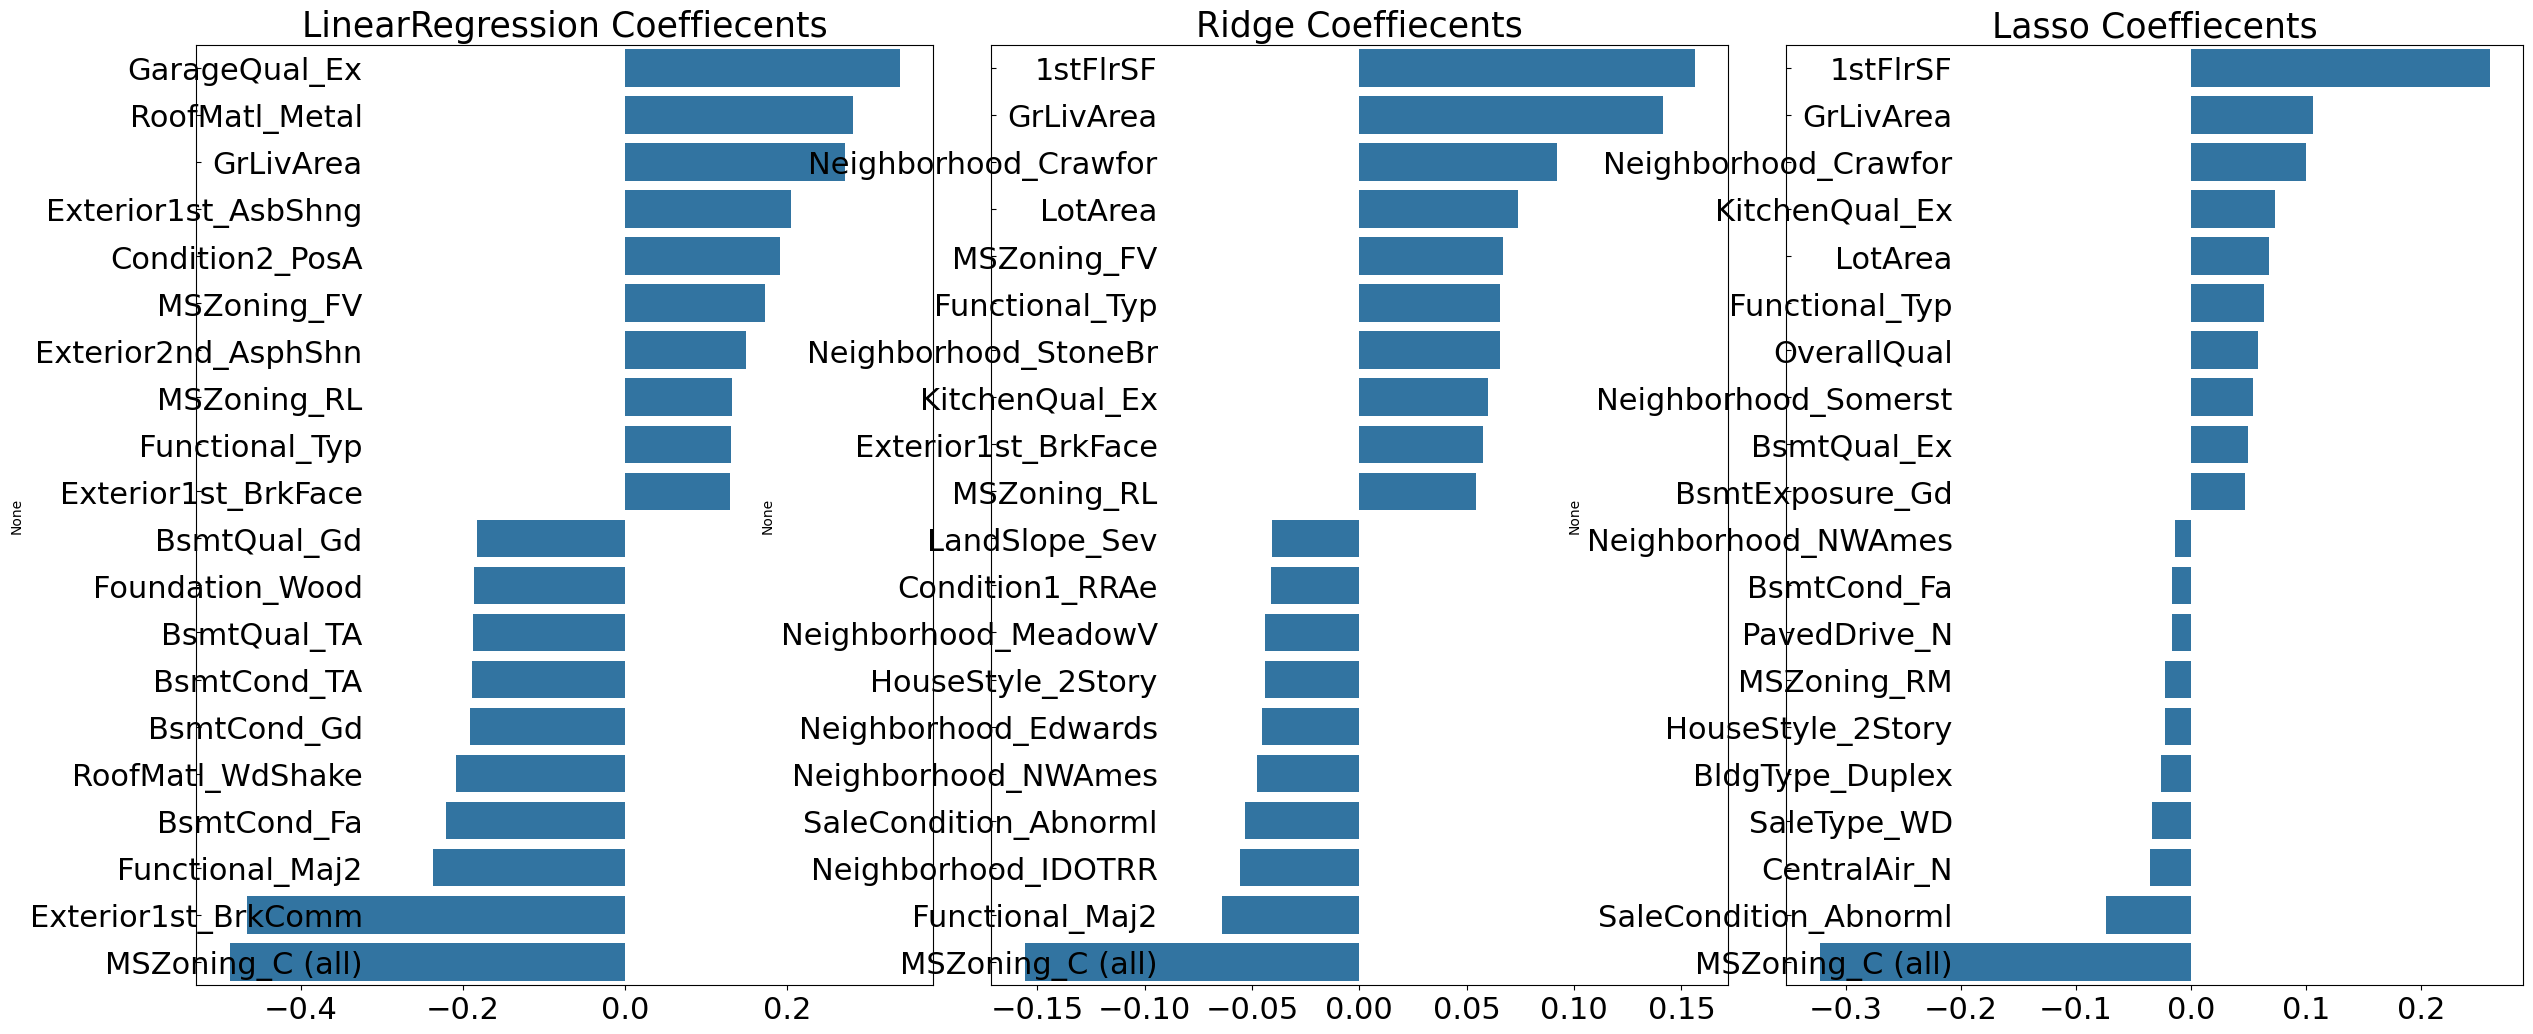

In [25]:
# 앞의 최적화 alpha값으로 학습데이터로 학습, 테스트 데이터로 예측 및 평가 수행.
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

# 모든 모델의 RMSE 출력
models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

# 모든 모델의 회귀 계수 시각화
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

### 3-3. 모델

#### 3-3-1. xgboost

In [26]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
best_xgb = print_best_params(xgb_reg, xgb_params)

XGBRegressor 5 CV 시 최적 평균 RMSE 값: 0.125, 최적 alpha:{'n_estimators': 1000}


#### 3-3-2. lightgbm

In [27]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
best_lgbm = print_best_params(lgbm_reg, lgbm_params)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001231 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2939
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 164
[LightGBM] [Info] Start training from score 12.020420
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001133 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2924
[LightGBM] [Info] Number of data points in the train set: 933, number of used features: 156
[LightGBM] [Info] Start training from score 12.025656
[LightGBM] [Warning] Found w

```
LGBMRegressor 5 CV 시 최적 평균 RMSE 값: 0.1203, 최적 alpha:{'n_estimators': 1000}
```

#### 3-3-3. catboost

In [28]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.2 MB/s eta 0:00:00


In [29]:
from catboost import CatBoostRegressor

cat_params = {'iterations': [1000]}

cat_reg = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=4,l2_leaf_reg=10,
                            subsample=0.6, colsample_bylevel=0.4)

best_cat = print_best_params(cat_reg, cat_params)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
1:	learn: 0.3710032	total: 4.15ms	remaining: 2.07s
2:	learn: 0.3617210	total: 5.62ms	remaining: 1.87s
3:	learn: 0.3526468	total: 7.25ms	remaining: 1.81s
4:	learn: 0.3432150	total: 8.97ms	remaining: 1.78s
5:	learn: 0.3346741	total: 10.4ms	remaining: 1.71s
6:	learn: 0.3266127	total: 12ms	remaining: 1.7s
7:	learn: 0.3193842	total: 13.6ms	remaining: 1.69s
8:	learn: 0.3120472	total: 15.1ms	remaining: 1.66s
9:	learn: 0.3051239	total: 16.6ms	remaining: 1.64s
10:	learn: 0.2980444	total: 18.1ms	remaining: 1.63s
11:	learn: 0.2913418	total: 19.5ms	remaining: 1.61s
12:	learn: 0.2855408	total: 21.2ms	remaining: 1.61s
13:	learn: 0.2803020	total: 22.7ms	remaining: 1.6s
14:	learn: 0.2745872	total: 24.3ms	remaining: 1.6s
15:	learn: 0.2688705	total: 25.9ms	remaining: 1.59s
16:	learn: 0.2640292	total: 27.3ms	remaining: 1.58s
17:	learn: 0.2586367	total: 28.8ms	remaining: 1.57s
18:	learn: 0.2542120	total: 30.5ms	remaining: 1.57s
19:	learn: 0.2500314	total: 32ms	remaining

```
CatBoostRegressor 5 CV 시 최적 평균 RMSE 값: 0.1125, 최적 alpha:{'iterations': 1000}
```

#### 3-3-4. 비교

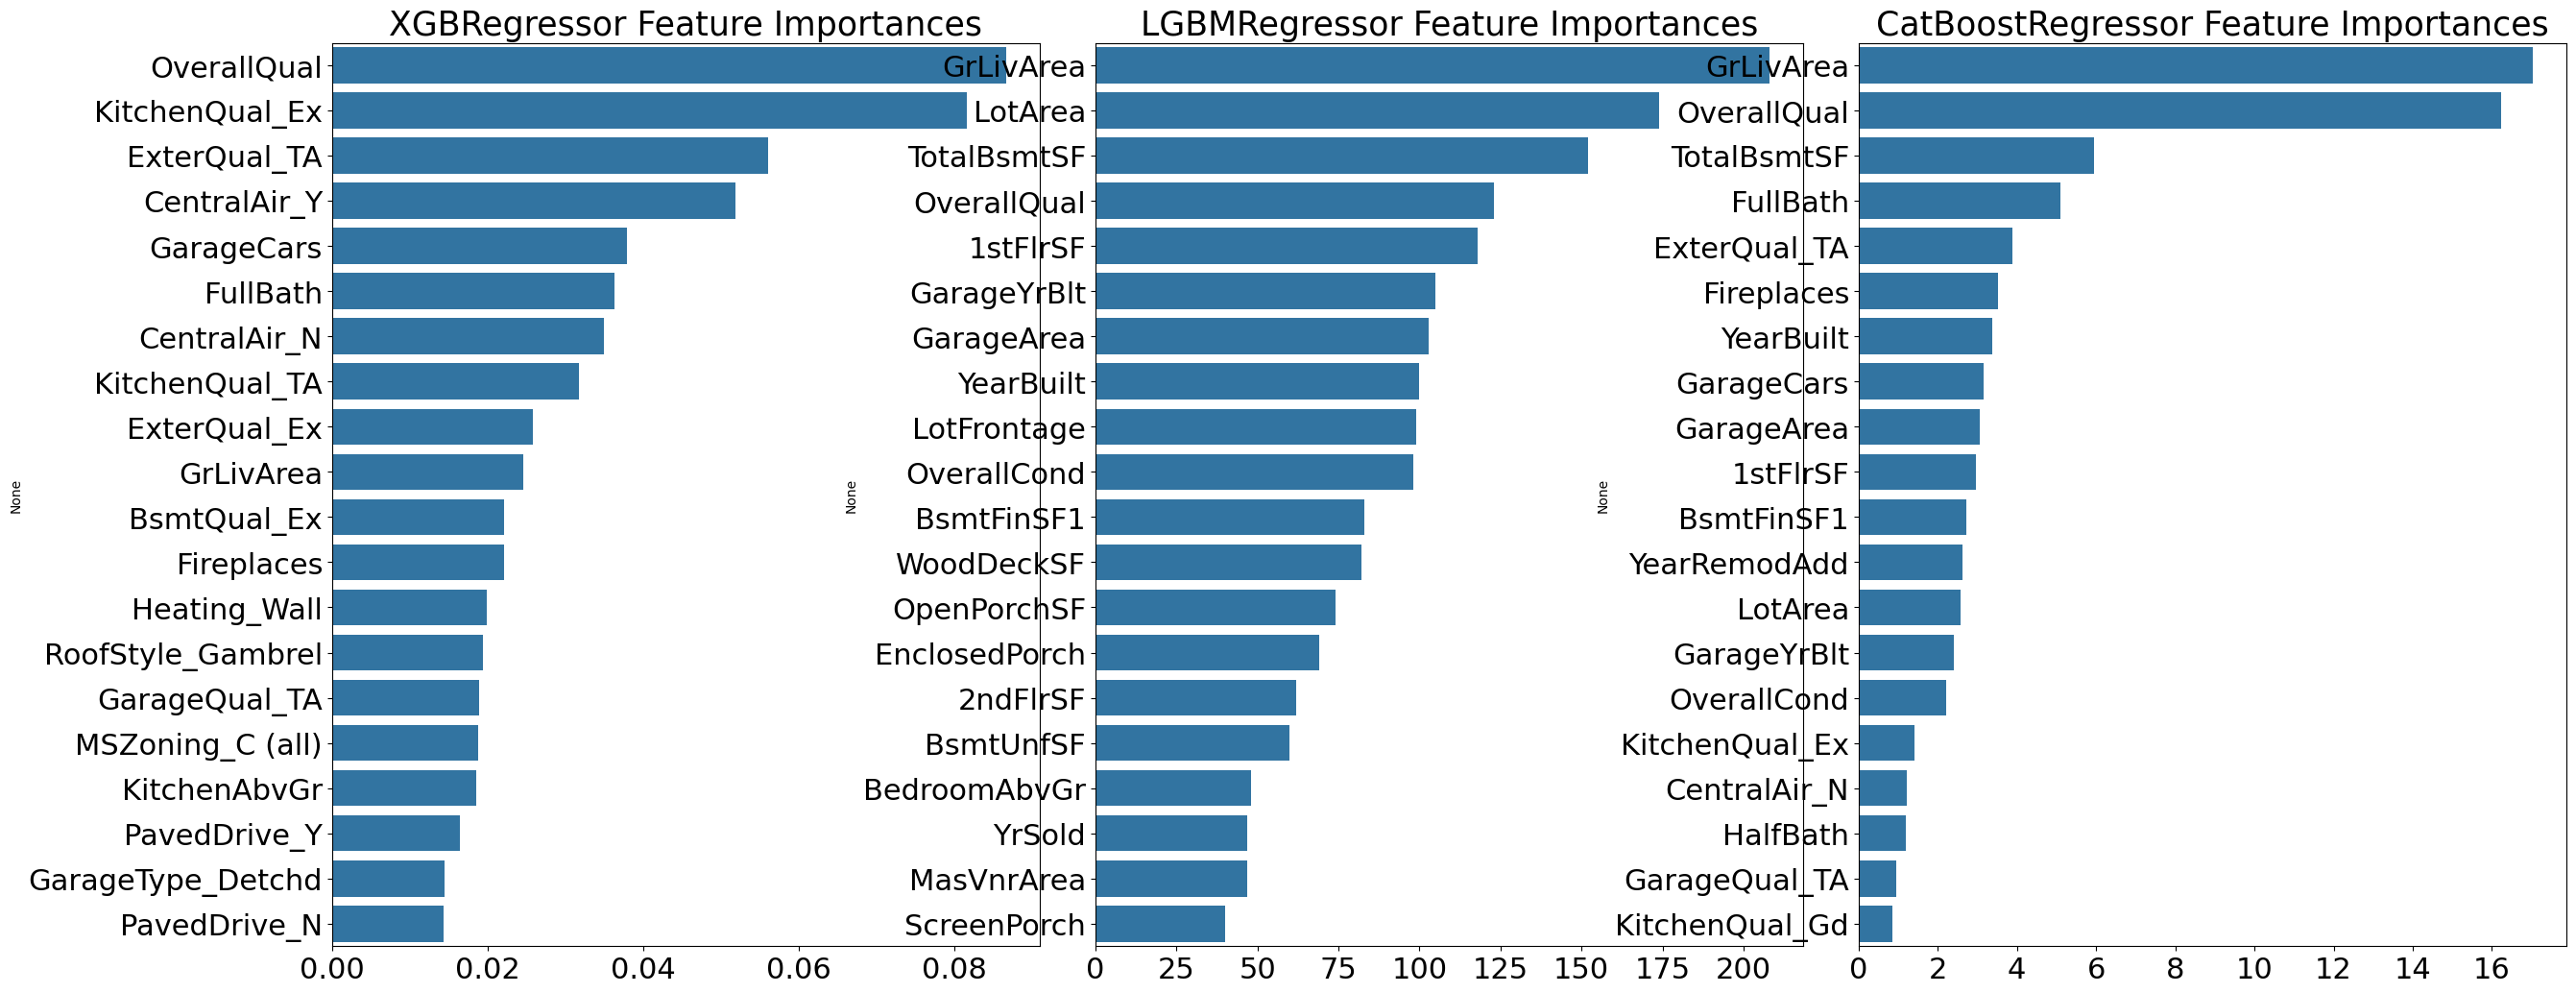

In [30]:
# 모델의 중요도 상위 20개의 피처명과 그때의 중요도값을 Series로 반환.
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X_features.columns  )
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    # 2개 회귀 모델의 시각화를 위해 2개의 컬럼을 가지는 subplot 생성
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=3)
    fig.tight_layout()
    # 입력인자로 받은 list객체인 models에서 차례로 model을 추출하여 피처 중요도 시각화.
    for i_num, model in enumerate(models):
        # 중요도 상위 20개의 피처명과 그때의 중요도값 추출
        ftr_top20 = get_top_features(model)
        axs[i_num].set_title(model.__class__.__name__+' Feature Importances', size=25)
        #font 크기 조정.
        for label in (axs[i_num].get_xticklabels() + axs[i_num].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i_num])

# 앞 예제에서 print_best_params( )가 반환한 GridSearchCV로 최적화된 모델의 피처 중요도 시각화
models = [best_xgb, best_lgbm, best_cat]
visualize_ftr_importances(models)

### 3-4. 개별 회귀 모델의 예측 결과 혼합을 통한 예측

In [31]:
def get_rmse_pred(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test , pred_value)
        rmse = np.sqrt(mse)
        print('{0} 모델의 RMSE: {1}'.format(key, rmse))

# 개별 모델의 학습
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)
# 개별 모델 예측
ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)

# 개별 모델 예측값 혼합으로 최종 예측값 도출
pred = 0.4 * ridge_pred + 0.6 * lasso_pred
preds = {'최종 혼합': pred,
         'Ridge': ridge_pred,
         'Lasso': lasso_pred}
#최종 혼합 모델, 개별모델의 RMSE 값 출력
get_rmse_pred(preds)

최종 혼합 모델의 RMSE: 0.11284977071517663
Ridge 모델의 RMSE: 0.1168652465139027
Lasso 모델의 RMSE: 0.1119810145227005


In [32]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05,
                       colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4,
                         subsample=0.6, colsample_bytree=0.4, reg_lambda=10, n_jobs=-1)
cat_reg = CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=4,l2_leaf_reg=10,
                            subsample=0.6, colsample_bylevel=0.4)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
cat_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)
cat_pred = cat_reg.predict(X_test)

pred = 0.3 * xgb_pred + 0.3 * lgbm_pred + 0.4*cat_pred
preds = {'최종 혼합': pred,
         'XGBM': xgb_pred,
         'LGBM': lgbm_pred,
         'CATM' : cat_pred
         }

get_rmse_pred(preds)

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2930
[LightGBM] [Info] Number of data points in the train set: 932, number of used features: 155
[LightGBM] [Info] Start training from score 12.029584
0:	learn: 0.3944864	total: 3.19ms	remaining: 3.18s
1:	learn: 0.3841964	total: 6.13ms	remaining: 3.06s
2:	learn: 0.3749441	total: 15.3ms	remaining: 5.07s
3:	learn: 0.3645947	total: 25.3ms	remaining: 6.3s
4:	learn: 0.3554276	total: 29.9ms	remaining: 5.95s
5:	learn: 0.3468821	total: 34.4ms	remaining: 5.7s
6:	learn: 0.3382752	total: 39ms	remaining: 5.54s
7:	learn: 0.3294675	total: 41.5ms	remaining: 5.15s
8:	learn: 0.3216369	total: 45.2ms	remaining: 4.98s
9:	learn: 0.3144098	total: 51.6ms	remaining: 5.11s
10:	lear

```
최종 혼합 모델의 RMSE: 0.11294803348777151
XGBM 모델의 RMSE: 0.11565641776891314
LGBM 모델의 RMSE: 0.11973930669985357
CATM 모델의 RMSE: 0.11582127800397533
```

### 3-5. 스태킹 앙상블 모델을 통한 회귀 예측

In [33]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성하기 위한 함수.
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds ):
    # 지정된 n_folds값으로 KFold 생성.
    kf = KFold(n_splits=n_folds, shuffle=False)
    #추후에 메타 모델이 사용할 학습 데이터 반환을 위한 넘파이 배열 초기화
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')

    for folder_counter , (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        #입력된 학습 데이터에서 기반 모델이 학습/예측할 폴드 데이터 셋 추출
        print('\t 폴드 세트: ',folder_counter,' 시작 ')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index]

        #폴드 세트 내부에서 다시 만들어진 학습 데이터로 기반 모델의 학습 수행.
        model.fit(X_tr , y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 기반 모델 예측 후 데이터 저장.
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 예측 후 데이터 저장.
        test_pred[:, folder_counter] = model.predict(X_test_n)

    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트 데이터로 생성
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)

    #train_fold_pred는 최종 메타 모델이 사용하는 학습 데이터, test_pred_mean은 테스트 데이터
    return train_fold_pred , test_pred_mean

In [34]:
# get_stacking_base_datasets( )은 넘파이 ndarray를 인자로 사용하므로 DataFrame을 넘파이로 변환.
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

# 각 개별 기반(Base)모델이 생성한 학습용/테스트용 데이터 반환.
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
cat_train, cat_test = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_n, 5)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.3647759	total: 9.3ms	remaining: 1.85s
5:	learn: 0.3561923	total: 11.1ms	remaining: 1.83s
6:	learn: 0.3479076	total: 12.6ms	remaining: 1.79s
7:	learn: 0.3403593	total: 14.2ms	remaining: 1.76s
8:	learn: 0.3314211	total: 15.8ms	remaining: 1.74s
9:	learn: 0.3231830	total: 17.3ms	remaining: 1.71s
10:	learn: 0.3163139	total: 18.8ms	remaining: 1.69s
11:	learn: 0.3097331	total: 20.3ms	remaining: 1.67s
12:	learn: 0.3023103	total: 21.9ms	remaining: 1.66s
13:	learn: 0.2962196	total: 23.5ms	remaining: 1.66s
14:	learn: 0.2904659	total: 24.9ms	remaining: 1.64s
15:	learn: 0.2843358	total: 26.4ms	remaining: 1.62s
16:	learn: 0.2785751	total: 28.1ms	remaining: 1.62s
17:	learn: 0.2735407	total: 29.7ms	remaining: 1.62s
18:	learn: 0.2681394	total: 31.3ms	remaining: 1.61s
19:	learn: 0.2633231	total: 32.8ms	remaining: 1.61s
20:	learn: 0.2588634	total: 34.4ms	remaining: 1.6s
21:	learn: 0.2539307	total: 35.9ms	remaining: 1.6s
22:	learn: 0.2497085	total: 37.7ms	re

In [35]:
# 개별 모델이 반환한 학습 및 테스트용 데이터 세트를 Stacking 형태로 결합.
Stack_final_X_train = np.concatenate((ridge_train, lasso_train,
                                      xgb_train, cat_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test,
                                     xgb_test, cat_test), axis=1)

# 최종 메타 모델은 라쏘 모델을 적용.
meta_model_lasso = Lasso(alpha=0.0005)

#기반 모델의 예측값을 기반으로 새롭게 만들어진 학습 및 테스트용 데이터로 예측하고 RMSE 측정.
meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test , final)
rmse = np.sqrt(mse)
print('스태킹 회귀 모델의 최종 RMSE 값은:', rmse)

스태킹 회귀 모델의 최종 RMSE 값은: 0.11139482301228726


### 3-6. 최종 비교

모델별 RMSE 비교 결과

| 모델 유형                      | 모델 이름                   | RMSE 값           |
|-------------------------------|-----------------------------|-------------------|
| 선형 모델                   | Ridge                       | 0.11687           |
|                               | Lasso                       | 0.11198           |
|                               | Ridge + Lasso (혼합)        | 0.11285           |
| 트리 기반 모델             | XGBoost (XGBM)              | 0.11566           |
|                               | LightGBM (LGBM)             | 0.11974           |
|                               | CatBoost (CATM)             | 0.11582           |
|                               | XGBM + LGBM + CATM (혼합)   | 0.11295           |
| 앙상블 모델                | 스태킹 회귀 모델            | **0.11139**       |


- 최고 성능 모델: 스태킹 회귀 모델 (RMSE = 0.11139)
- Lasso 단독 모델도 매우 우수한 성능 (RMSE = 0.11198)

## 4.제출용 Test 데이터 전처리 진행

In [36]:
X_train.shape

(932, 266)

In [37]:
## test_data를 받아오기
test = pd.read_csv('./test.csv')

# Null 이 너무 많은 컬럼들과 불필요한 컬럼 삭제
test.drop(['Id','PoolQC' , 'MiscFeature', 'Alley', 'Fence','FireplaceQu'], axis=1 , inplace=True)

num_cols = test.select_dtypes(include=['number']).columns
test[num_cols] = test[num_cols].fillna(test[num_cols].mean())
test_ohe1 = pd.get_dummies(test)
test_ohe2 = test_ohe1.reindex(columns=X_train.columns, fill_value=0)

# 편향 전처리 진행
test_ohe2[skew_features_top.index] = np.log1p(test_ohe2[skew_features_top.index])
test_ohe2 = pd.get_dummies(test_ohe2)

test_ohe2.shape

(292, 266)

In [38]:
## sample_data를 받아오기
sample = pd.read_csv('./sample_submission.csv')

# SalePrice 가 0으로 차있는 sample
sample

,Id,SalePrice
0,86,0
1,227,0
2,492,0
3,64,0
4,576,0
...,...,...
287,1271,0
288,903,0
289,1019,0
290,312,0


In [42]:
X_test_final_n = test_ohe2.values

ridge_test_final = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_final_n, 5)[1]
lasso_test_final = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_final_n, 5)[1]
xgb_test_final   = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_final_n, 5)[1]
cat_test_final  = get_stacking_base_datasets(cat_reg, X_train_n, y_train_n, X_test_final_n, 5)[1]

Stack_final_X_test_final = np.concatenate((ridge_test_final,
                                           lasso_test_final,
                                           xgb_test_final,
                                           cat_test_final), axis=1)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
4:	learn: 0.3647759	total: 11.3ms	remaining: 2.25s
5:	learn: 0.3561923	total: 13.2ms	remaining: 2.19s
6:	learn: 0.3479076	total: 14.8ms	remaining: 2.1s
7:	learn: 0.3403593	total: 16.4ms	remaining: 2.03s
8:	learn: 0.3314211	total: 18ms	remaining: 1.99s
9:	learn: 0.3231830	total: 19.5ms	remaining: 1.93s
10:	learn: 0.3163139	total: 21.2ms	remaining: 1.9s
11:	learn: 0.3097331	total: 22.7ms	remaining: 1.87s
12:	learn: 0.3023103	total: 24.5ms	remaining: 1.86s
13:	learn: 0.2962196	total: 26.2ms	remaining: 1.84s
14:	learn: 0.2904659	total: 27.6ms	remaining: 1.81s
15:	learn: 0.2843358	total: 29.3ms	remaining: 1.8s
16:	learn: 0.2785751	total: 31ms	remaining: 1.79s
17:	learn: 0.2735407	total: 32.5ms	remaining: 1.77s
18:	learn: 0.2681394	total: 34.2ms	remaining: 1.76s
19:	learn: 0.2633231	total: 35.7ms	remaining: 1.75s
20:	learn: 0.2588634	total: 37.3ms	remaining: 1.74s
21:	learn: 0.2539307	total: 38.8ms	remaining: 1.73s
22:	learn: 0.2497085	total: 40.7ms	remain

In [43]:
pred = meta_model_lasso.predict(Stack_final_X_test_final)
# 학습시 로그변환한 target을 썻으니 결과값을 다시 복원해야합니다
pred_exp = np.expm1(pred)

# sample 파일에 예측 값을 넣어주고
sample["SalePrice"] = pred_exp

# csv로 저장하기
sample.to_csv("./submission.csv", index=False)

In [44]:
# 제출부분과 크기가 맞는지 확인
pred_exp.shape

(292,)

In [45]:
pred_exp

array([265783.5606835 , 263396.02950493, 145579.93890663, 136816.85946238,
       113606.5314967 , 309445.91645031, 235967.63216658,  84042.36015277,
       175760.25497996, 134390.63850642, 284719.63721407, 232255.34667558,
        67796.29792495,  81570.11557112, 132789.92776802, 133379.35729232,
       126274.10504791, 284220.92908636, 218722.74797636, 115959.44682297,
       264400.65257329, 147551.26862114, 136327.07163258, 212882.09887843,
       119110.18851743, 194465.33700367, 141556.77851558, 144973.31517248,
       354360.33834494, 191188.00205985, 194037.37887466, 184265.86760855,
       156766.09256876, 147721.77997069, 173819.60684567, 355066.70265105,
       102212.35933641, 206121.32231107, 235362.19900363, 136809.99583761,
       308578.21961338, 212612.96512863, 118708.66405258, 319551.50878368,
       124973.10836967, 165186.34675579, 121978.56036796, 132118.5386694 ,
       211723.416893  , 171073.72293231, 204063.97462736, 137268.56313154,
       214287.32228984, 1